# Forest estate modelling input data prep (BC RIA landbase)

Gregory Paradis (gregory.paradis@ubc.ca)

This notebook implements a data processing pipeline to prepare input datasets for the landscape-level forest estate modelling (e.g., ws3, SpaDES, Patchworks, etc.)

This notebook imports various publicly-available VRI datasets, extracts the RIA landbase subset, stratifies features in a way that can work for the harvesting and carbon analyses we are planning, and builds VDYP and TIPSY yield curves.

The source datasets are all freely available, but need to be downloaded and unpacked to paths that match the paths specified further down in the notebook (or modify the path parameter values). We list links to datasets used below.

## Datasets

Links to source datasets used in this notebook.

[FADM - Timber Supply Area (TSA)](https://catalogue.data.gov.bc.ca/dataset/8daa29da-d7f4-401c-83ae-d962e3a28980)

[VRI - 2019 - Forest Vegetation Composite Rank 1 Layer (R1)](https://catalogue.data.gov.bc.ca/dataset/2ebb35d8-c82f-4a17-9c96-612ac3532d55)

[VRI - 2019 - Variable Density Yield Projection 7 (VDYP7) Input Polygon](https://catalogue.data.gov.bc.ca/dataset/57513aaa-c0a6-41a9-b2a8-b980b1604ee6)

[Site Productivity - Site Index by Tree Species](https://catalogue.data.gov.bc.ca/dataset/04ad45c3-0fdc-4506-bdb4-252c45a63459)

[Generalized Forest Cover Ownership](https://catalogue.data.gov.bc.ca/dataset/5fc4e8ce-dd1d-44fd-af17-e0789cf65e4ehttps://catalogue.data.gov.bc.ca/dataset/5fc4e8ce-dd1d-44fd-af17-e0789cf65e4e)

See also [VRI code lists](https://www.for.gov.bc.ca/hfp/publications/00026/fs708-14-appendix_d.htm) for some metadata that can help you decode and understand some of the datasets we use.

## Software dependencies

Python packages imported below must be installed. We also use a [patched branch](https://github.com/gparadis/ArcRasterRescue/tree/bug-fix_transform) of the ArcRasterRescue package to export species-wise site productivity raster data layers from the proprietary ESRI File Geodatabase file.

Also check this out for BC raster data:

https://hectaresbc.ca/app/habc/HaBC.html

Clone the correct branch of the ArcRasterRescue repository from GitHub, and compile the executable.

Import required packages.

In [1]:
import os
import matplotlib.pyplot as plt
import datatable
import pandas as pd
import geopandas as gpd
import pickle
import seaborn as sns
from shapely.ops import unary_union, Polygon
import numpy as np
from numpy.polynomial import Polynomial
import csv
from scipy.optimize import curve_fit
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.io import MemoryFile
from geocube.api.core import make_geocube
import subprocess
import shlex
from rasterio.plot import show, show_hist
import warnings
from pympler import asizeof
import ipcmagic
import ipyparallel as ipp
import mapply
import swifter
import fiona
import affine
from osgeo import gdal
import glob
import operator
import distance
from scipy.optimize import curve_fit as _curve_fit
from functools import partial, wraps
import itertools

Set global notebook parameters.

In [2]:
pd.set_option('display.max_rows', 300) # bump this parameter up if you want to see more table rows
pd.set_option('display.max_columns', 30) # bump this parameter up if you want to see more table rows

warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
%config Completer.use_jedi = False # patch autocomplete bug

Launch and set up `ipyparallel` cluster.

In [3]:
#%ipcluster --help
%ipcluster start -n 16
rc = ipp.Client()
lbview = rc.load_balanced_view()

IPCluster is ready! (5 seconds)


Define path strings and such.

In [4]:
vri_vclr1p_path = '../data/bc/vri/2019/VEG_COMP_LYR_R1_POLY.gdb'
ria_stands_path = './data/veg_comp_lyr_r1_poly-ria.shp'
tsa_boundaries_path = '../data/bc/tsa/FADM_TSA.gdb/'
ria_maptiles_path = 'ria_maptiles.csv'
vdyp_input_pandl_path = './data/VEG_COMP_VDYP7_INPUT_POLY_AND_LAYER_2019.gdb'

site_prod_bc_gdb_path = './data/Site_Prod_BC.gdb/' # ESRI File Geodatabase containing 22 species-wise site productivity raster layers

tsa_boundaries_feather_path = './data/tsa_boundaries.feather'
#ria_vri_vclr1p_final_feather_path = './data/ria_vri_vclr1p_final.feather'
ria_vri_vclr1p_checkpoint1_feather_path = './data/ria_vri_vclr1p_checkpoint1.feather'
ria_vri_vclr1p_checkpoint2_feather_path = './data/ria_vri_vclr1p_checkpoint2.feather'
ria_vri_vclr1p_checkpoint3_feather_path = './data/ria_vri_vclr1p_checkpoint3.feather'
ria_vri_vclr1p_checkpoint4_feather_path = './data/ria_vri_vclr1p_checkpoint4.feather'
ria_vri_vclr1p_checkpoint5_feather_path = './data/ria_vri_vclr1p_checkpoint5.feather'
ria_vri_vclr1p_checkpoint6_feather_path = './data/ria_vri_vclr1p_checkpoint6.feather'
ria_vri_vclr1p_checkpoint7_feather_path = './data/ria_vri_vclr1p_checkpoint7.feather'
ria_vri_vclr1p_checkpoint8_feather_path = './data/ria_vri_vclr1p_checkpoint8.feather'
vri_vclr1p_categorical_columns_path = './data/vri_vclr1p_categorical_columns'
ria_vclr1p_feature_tif_path = './data/ria_vclr1p_feature_raster.tif'
#_feather_path = './data/.feather'

arc_raster_rescue_exe_path = '../ArcRasterRescue/build/arc_raster_rescue.exe'
siteprod_gdb_path = './data/Site_Prod_BC.gdb/'
siteprod_tmpexport_tif_path_prefix = './data/site_prod_bc_'
siteprod_tif_path = './data/siteprod.tif'

vdyp_ply_feather_path = './data/vdyp_ply.feather'
vdyp_lyr_feather_path = './data/vdyp_lyr.feather'
vdyp_results_tsa_pickle_path_prefix = './data/vdyp_results-tsa'
vdyp_results_pickle_path = './data/vdyp_results.pkl'
vdyp_curves_smooth_tsa_feather_path_prefix = './data/vdyp_curves_smooth-tsa'
vdyp_curves_smooth_feather_path = './data/vdyp_curves_smooth.feather'

tipsy_params_path_prefix = './data/tipsy_params_tsa'

ria_tsas = ['08', '16', '24', '40', '41']
#ria_tsas = ['08']
si_levels = ['L', 'M', 'H']

raster_pxw = 100
raster_pxh = 100

tipsy_params_columns = [line.strip() for line in open('./data/tipsy_params_columns').readlines()]

In [5]:
species_spruce = ['S', 'SB', 'SE', 'SN', 'SS', 'SW', 'SX', 'SXE', 'SXL', 'SXW']
species_pine = ['P', 'PA', 'PJ', 'PL', 'PLC', 'PLI', 'PM']
species_fir = ['B', 'BA', 'BB', 'BG', 'BL', 'BM', 'BP']
species_larch = ['L', 'LA', 'LS', 'LT', 'LW']
species_cedar = ['C', 'CW']
species_hemlock = ['HM', 'HWI', 'HW']
species_douglasfir = ['F', 'FD', 'FDC', 'FDI']

species_aspen = ['AC', 'ACB', 'ACT', 'AD', 'AT', 'AX']
species_birch = ['E', 'EA', 'EB', 'EE', 'EP', 'EW', 'EXP']
species_willow = ['W','WA', 'WB', 'WD', 'WP', 'WS']
species_alder = ['D', 'DR']
species_cherry = ['V']
species_dogwood = ['GP']
species_oak = ['Q']
species_maple = ['M', 'MB', 'MV']

Download and compile ArcRasterRescue package.

In [6]:
if not os.path.isfile(arc_raster_rescue_exe_path):
    !git clone https://github.com/gparadis/ArcRasterRescue.git
    !cd ArcRasterRescue; git checkout bug-fix_transform
    !mkdir ArcRasterRescue/build
    !cd ArcRasterRescue/build; cmake -DCMAKE_BUILD_TYPE=RelWithDebInfo ..; make

Load TSA boundary data for the 5 TSAs in the RIA landbase and compile a single polygon defining RIA landbase extent.

In [7]:
import_tsa_boundaries_data = 0
if import_tsa_boundaries_data:
    tsa_boundaries = gpd.read_file(tsa_boundaries_path)
    tsa_boundaries = tsa_boundaries[['TSA_NUMBER', 'geometry']].loc[tsa_boundaries.TSA_NUMBER.isin(ria_tsas)].dissolve(by='TSA_NUMBER')
    tsa_boundaries['geometry'] = tsa_boundaries.geometry.simplify(tolerance=1000, preserve_topology=True)
    tsa_boundaries.to_feather(tsa_boundaries_feather_path)
else:
    tsa_boundaries = gpd.read_feather(tsa_boundaries_feather_path)

#tsa_extent_all = Polygon(unary_union(list(tsa_boundaries.geometry.values)).exterior) 

Load VRI features (_vegetation composite layer and R1 polygon_ dataset), masked to RIA landbase extent. 

In [8]:
%%time
import_vri_vclr1p_data = 0 # set to False to use cached data 
if import_vri_vclr1p_data:
    print('loading VRI data from source')
    def load_vri_vclr1p(vri_vclr1p_path, tsa_code, tsa_mask, ignore_geometry=False):
        import geopandas as gpd # local import required to play nice with ipp engines
        result = gpd.read_file(vri_vclr1p_path, 
                               mask=tsa_mask,
                               ignore_geometry=ignore_geometry)
        result['tsa_code'] = tsa_code
        return result
    tsa_gdfs = lbview.map_async(load_vri_vclr1p, 
                                [vri_vclr1p_path for tsa in ria_tsas],
                                ria_tsas, 
                                [tsa_boundaries.loc[tsa].geometry for tsa in ria_tsas],
                                ordered=True)
    rc.wait_interactive()
    ria_vri_vclr1p = pd.concat(tsa_gdfs, axis=0, ignore_index=True)
    ria_vri_vclr1p.to_feather(ria_vri_vclr1p_checkpoint1_feather_path)
else:
    print('loading VRI data from checkpoint1 feather')
    ria_vri_vclr1p = gpd.read_feather(ria_vri_vclr1p_checkpoint1_feather_path)

f = ria_vri_vclr1p

loading VRI data from checkpoint1 feather
CPU times: user 1min 19s, sys: 16.7 s, total: 1min 36s
Wall time: 5min 55s


Extract site productivity raster data from proprietary ESRI File Geodatabase, and export it to species-wise GeoTIFF layers, patch the missing CRS metadata, and stack everything into a single multi-band GeoTIFF.

In [9]:
# map layer indices to layer species codes
result = subprocess.run(shlex.split('%s %s' % (arc_raster_rescue_exe_path, siteprod_gdb_path)), capture_output=True)
siteprod_layerspecies =  {int(i):vv[10:].upper() 
                          for i, vv in [v.strip().split(' ') 
                                        for v in result.stdout.decode().split('\n')[1:] if v]}
siteprod_specieslayer =  {vv[10:].upper():int(i) 
                          for i, vv in [v.strip().split(' ') 
                                        for v in result.stdout.decode().split('\n')[1:] if v]}

if not os.path.isfile(siteprod_tif_path):
    # export species-wise raster layers to 22 GeoTIFFs
    print('Extracting siteprod raster data from ESRI File Geodatabase...')
    for i, species in site_prod_bc_layerspecies.items():
        print('... processing species', species)
        args = '%s %s %i %s' % (arc_raster_rescue_exe_path, 
                                site_prod_bc_gdb_path, 
                                i, 
                                '%s%s.tif' % (siteprod_tmpexport_tif_path_prefix, species))
        subprocess.run(shlex.split(args))

    # patch exported GeoTIFF files with missing CRS metadata    
    #for species in site_prod_bc_specieslayer.keys():
    #    with rio.open('%s%s.tif' % (siteprod_tmpexport_tif_path_prefix, species), 'r+') as src:
    #        src.crs = rio.crs.CRS({"init": "epsg:3005"}) # BC Albers equal area geographic projection

    # stack species-wise raster layers into a single multi-band GeoTIFF
    file_list = sorted(glob.glob('%s*.tif' % siteprod_tmpexport_tif_path_prefix))
    with rio.open(file_list[0]) as src:
        meta = src.meta
        meta.update(count=len(file_list), 
                    compress='lzw', 
                    crs=rio.crs.CRS({"init": "epsg:3005"})) # BC Albers equal area geographic projection)

    with rio.open(siteprod_tif_path, 'w', **meta) as dst:
        print('\nStacking siteprod raster data into a single multiband GeoTIFF file...')
        for id, layer in enumerate(file_list, start=1):
            print('... processing species', siteprod_layerspecies[id-1])
            with rio.open(layer) as src:
                dst.write_band(id, src.read(1))
            os.remove(layer) # delete intermediate GeoTIFF (not needed anymore)

Define a species code lookup dict to map VRI species codes to one of the 22 siteprod species codes. We built the key list for this dict by compiling unique values from the `SPECIES_CD_1` column in the VRI feature dataset, and netting out the 22 siteprod species codes. Assignments with question mark comments may need to be revisited. If this project is ported to a different landbase, this list would likely need to be expanded (we can eventually just build a BC-wide species code map from the unfiltered VRI dataset).

In [10]:
def siteprod_species_lookup(s):
    spp = {'AC': 'AT',
           'PLI': 'PL',
           'FDI': 'FD',
           'S': 'SW',
           'SXL': 'SX',
           'ACT': 'AT',
           'E': 'EP',
           'P': 'PL',
           'EA': 'EP',
           'SXW': 'SX',
           'W': 'EP', # ?
           'T': 'LT', # ?
           'L': 'LT',
           'B': 'BL',
           'ACB': 'AT',
           'PJ': 'PL', # ?
           'WS': 'EP',
           'LA':'LT',
           'AX':'AT',
           'BB':'BL',
           'H':'HW', 
           'BM':'BL',
           'V':'DR',
           'F':'FD',
           'C':'CW',
           'XC':'PL',
           'XD':'SW',
           'X':'SW',
           'A':'AT',
           'D':'DR',
           'Z':'SW',
           'Q':'AT',
           'Y':'YC',
           'R':'DR',
           'G':'DR'} # ?
    try:
        result = spp[s]
    except:
        try:
            result = spp[s[0]]
        except:
            #result = 'X'
            print(s)
            assert False # bad species code
    return result
    
species_list = list(set().union(*[ria_vri_vclr1p['SPECIES_CD_%i' % i].unique() for i in range(1, 7)]))
species_list = [s for s in species_list if s is not None]

Clean and filter VRI feature dataset, and cast some columns to `category` data type (reduces memory footprint, and maybe speeds up some processing).

Then, for each feature in the VRI dataaset, extract mean SI data from the pixels in the siteprod raster layer corresponding the leading species. This step is computationally intensive (takes about 30 minutes to run), so this is a good time to go for a walk.

In [11]:
process_checkpoint2 = 0
if process_checkpoint2:
    for i in range(1, 7):
        f['SPECIES_CD_%i' % i].fillna('X', inplace=True)
        f['SPECIES_PCT_%i' % i].fillna(0, inplace=True)
    f['SOIL_NUTRIENT_REGIME'].fillna('X', inplace=True)
    f['SOIL_MOISTURE_REGIME_1'].fillna('X', inplace=True)
    f['SITE_POSITION_MESO'].fillna('X', inplace=True)
    f['BCLCS_LEVEL_3'].fillna('X', inplace=True)
    f['BCLCS_LEVEL_4'].fillna('X', inplace=True)
    f['BCLCS_LEVEL_5'].fillna('X', inplace=True)
    f['BEC_VARIANT'].fillna('X', inplace=True)
    f['LIVE_STAND_VOLUME_125'].fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP1_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP2_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP3_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP4_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP5_125.fillna(0, inplace=True)
    f.LIVE_VOL_PER_HA_SPP6_125.fillna(0, inplace=True)
    f = f[f.BCLCS_LEVEL_2 == 'T'] # implies f.BCLCS_LEVEL_1 == 'V'
    #f = f[f.BCLCS_LEVEL_5 != 'OP']
    f = f[f.NON_PRODUCTIVE_CD != None]
    f = f[f.FOR_MGMT_LAND_BASE_IND == 'Y']
    f = f[~f.BEC_ZONE_CODE.isin(['BAFA', 'IMA'])]
    f = f[f.PROJ_AGE_1 >= 30]
    f = f[f.BASAL_AREA >= 5]
    f = f[f.LIVE_STAND_VOLUME_125 >= 1]
    f.shape
    #vri_vclr1p_categorical_columns = open(vri_vclr1p_categorical_columns_path).read().split('\n')
    #for c in vri_vclr1p_categorical_columns: 
    #    f[c] = f[c].astype('category')
    if 1:
        with rio.open(siteprod_tif_path) as src:
            def mean_siteprod(r):
                a, _ = mask(src, r.geometry, crop=True)
                s = r.SPECIES_CD_1 
                s = s if s in siteprod_specieslayer else siteprod_species_lookup(s)
                i = siteprod_specieslayer[s]
                aa = a[i]
                return np.mean(aa[aa > 0])
            f['siteprod'] = f.swifter.apply(mean_siteprod, axis=1)
    f.to_feather(ria_vri_vclr1p_checkpoint2_feather_path)
else:
    print('loading VRI data from checkpoint2 feather')
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint2_feather_path)

loading VRI data from checkpoint2 feather


Recompile VRI merchantable volume data into species-wise columns.

In [12]:
f.reset_index(inplace=True)

In [13]:
process_checkpoint3 = 0
if process_checkpoint3:
    def compile_species_vol(df, species):
        import swifter
        return df.swifter.apply(lambda r: sum(r['LIVE_VOL_PER_HA_SPP%i_125' % i] 
                                              for i in range(1, 7)
                                              if r['SPECIES_CD_%i' % i] == species), axis=1)
    cols = list(itertools.chain.from_iterable(['LIVE_VOL_PER_HA_SPP%i_125' % i]+['SPECIES_CD_%i' % i] for i in range(1, 7)))    
    f_ = f[cols]
    result = lbview.map_async(compile_species_vol, 
                              [f_]*len(species_list), 
                              species_list, 
                              ordered=True)
    rc.wait_interactive()
    
    for i, species in enumerate(species_list):
        print('compiling species', species)
        f['live_vol_per_ha_125_%s' % species] = result[i]
    f.to_feather(ria_vri_vclr1p_checkpoint3_feather_path)
else:
    print('loading VRI data from checkpoint3 feather')
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint3_feather_path)

loading VRI data from checkpoint3 feather


In [14]:
def is_conif(species_code):
    return species_code[:1] in ['B', 'C', 'F', 'H', 'J', 'L', 'P', 'S', 'T', 'Y']


def is_decid(species_code):
    return species_code[:1] in ['A', 'D', 'E', 'G', 'M', 'Q', 'R', 'U', 'V', 'W']


def pconif(r):
    return sum(r['SPECIES_PCT_%i' % i] for i in range(1, 7) if is_conif(r['SPECIES_CD_%i' % i])) / 100.


def pdecid(r):
    return sum(r['SPECIES_PCT_%i' % i] for i in range(1, 7) if is_decid(r['SPECIES_CD_%i' % i])) / 100.
    

def classify_stand_cdm(r):
    # Classify stand (from VRI record r) as one of: conif (c), decid (d), or mixed (m), where
    #   c >= 80% softwood
    #   d >= 80% hardwood
    #   m otherwise
    if pconif(r) >= 0.8:
        return 'c'
    elif pdecid(r) >= 0.8:
        return 'd'
    else:
        return 'm'
    
def classify_stand_forest_type(r):
    # to (approximately) match TSA 41 TSR data package AU regeneration logic
    if pconif(r) >= 0.75:
        return 1 # pure conif
    elif pconif(r) >= 0.50:
        return 2 # conif mix
    elif pconif(r) >= 0.25:
        return 3 # decid mix
    else:
        return 4 # pure decid

In [15]:
# definititely best one yet!
def stratify_stand(r, lexmatch=False, lexmatch_fieldname_suffix='_lexmatch'):
    result = ''
    if lexmatch:
        result += 3 * r['BEC_ZONE_CODE%s' % lexmatch_fieldname_suffix]
        result += '_'
        #result += r.BCLCS_LEVEL_5
        #result += '_'
        result += 2 * r['SPECIES_CD_1%s' % lexmatch_fieldname_suffix]
        if r.BCLCS_LEVEL_4 == 'TM' and r.SPECIES_CD_2 != None:
            result += '+' + r['SPECIES_CD_2%s' % lexmatch_fieldname_suffix]
    else:
        result += r.BEC_ZONE_CODE
        result += '_'
        #result += r.BCLCS_LEVEL_5
        #result += '_'
        result += r.SPECIES_CD_1
        if r.BCLCS_LEVEL_4 == 'TM' and r.SPECIES_CD_2 != None:
            result += '+' + r.SPECIES_CD_2
    return result

In [16]:
f['BEC_ZONE_CODE_lexmatch'] = f.BEC_ZONE_CODE.str.ljust(4, fillchar='x')
for i in range(1, 3):
    f['SPECIES_CD_%i_lexmatch' % i] = f['SPECIES_CD_%i' % i].str.ljust(4, 'x')
    f['SPECIES_CD_%i_lexmatch' % i] = f['SPECIES_CD_%i' % i].str[:1] + f['SPECIES_CD_%i' % i]

stratify_stand = stratify_stand
stratify_stand_lexmatch = partial(stratify_stand, lexmatch=True)

f['stratum'] = f.swifter.apply(stratify_stand, axis=1)
f['stratum_lexmatch'] = f.swifter.apply(stratify_stand_lexmatch, axis=1)

Pandas Apply:   0%|          | 0/1224701 [00:00<?, ?it/s]

In [17]:
stratum_col = 'stratum'

In [18]:
#f['forest_type'] = f.reset_index().swifter.apply(classify_stand_forest_type, axis=1)
f['forest_type'] = f.apply(classify_stand_forest_type, axis=1)

In [19]:
f.to_feather(ria_vri_vclr1p_checkpoint4_feather_path)

In [20]:
if 0: # roll back if screwed up further down
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint4_feather_path)

In [21]:
#f = f.reset_index().set_index('tsa_code')

Loop over TSAs and run notebook 01_run-tsa_step1.

In [22]:
vdyp_curves_smooth = {}
vdyp_results = {}
tipsy_params = {}
tipsy_curves = {}
scsi_au = {}
au_scsi = {}
results = {}

In [23]:
if 0:
    def process_vdyp_out(vdyp_out, volume_flavour='Vdwb', min_age=30, max_age=300, 
                         sigma_c1=10, sigma_c2=0.4, dx_c1=0.5, dx_c2=10,
                         window=10,  skip1=0, skip2=30, maxfev=100000,
                         body_fit_func=body_fit_func, body_fit_func_bounds_func=body_fit_func_bounds_func,
                         toe_fit_func=toe_fit_func, toe_fit_func_bounds_func=toe_fit_func_bounds_func):
        vdyp_out_concat = pd.concat([v for v in vdyp_out.values() if type(v) == pd.core.frame.DataFrame])
        c = vdyp_out_concat.groupby(level='Age')[volume_flavour].median()
        c = c[c > 0]
        c = c[c.index >= min_age]
        x = c.index.values
        y = c.rolling(window=window, center=True).median().values
        x, y = x[y > 0], y[y > 0]
        x, y = x[skip1:], y[skip1:]
        #return x, y
        y_mai = pd.Series(y / x, x)
        y_mai_max_age = y_mai.idxmax()
        sigma = (np.abs(x - y_mai_max_age) + sigma_c1)**sigma_c2
        popt, pcov = curve_fit(body_fit_func, x, y, bounds=body_fit_func_bounds_func(x), maxfev=maxfev, sigma=sigma)
        x = np.array(range(1, max_age))
        y = fit_func1(x, *popt)
        dx = max(0, dx_c1 * popt[2] - dx_c2)
        print(dx, dx_c1, popt[2], dx_c2)
        x, y, (i1, popt_toe) = fill_curve_left(x, y, skip=skip2, dx=dx, maxfev=maxfev,
                                               toe_fit_func=toe_fit_func, toe_fit_func_bounds_func=toe_fit_func_bounds_func)
        print(popt_toe)
        return x, y

In [24]:
kwarg_overrides = {'08':{('BWBS_SB', 'H'):{'skip1':30},
                         ('BWBS_S', 'L'):{'skip1':50},
                         ('SWB_S', 'L'):{'skip1':30},
                         ('BWBS_AT', 'H'):{'skip1':30}},
                   '16':{('SWB_SX', 'L'):{'skip1':30}},
                   '24':{('ESSF_BL', 'L'):{'skip1':30}},
                   '40':{('BWBS_SX', 'L'):{'skip1':30},
                         ('SWB_SX', 'L'):{'skip1':60, 'dx_c1':1., 'dx_c2':0.}},
                   '41':{('ESSF_BL', 'L'):{'skip1':60},
                         ('ESSF_SE', 'M'):{'skip1':30}}}

In [25]:
if 0:
    #kwarg_overrides = {'08':{('BWBS_SB', 'H'):{'skip1':30},
    #                        ('BWBS_AT', 'H'):{'skip1':30}},
    #                   '16':{('SWB_SX', 'L'):{'skip1':30}},
    #                   '24':{},
    #                   '40':{('BWBS_SX', 'L'):{'skip1':30}},
    #                   '41':{}}

    tsa = '41'
    vdyp_curves_smooth_tsa_feather_path = '%s%s.feather' % (vdyp_curves_smooth_tsa_feather_path_prefix, tsa)
    #if not os.path.isfile(vdyp_curves_smooth_tsa_feather_path):
    if 1:
        figsize = (8, 6)
        plot = 1
        vdyp_smoothxy = {}
        palette_flavours=['RdPu', 'Blues', 'Greens', 'Greys']
        palette = sns.color_palette('Greens', 3)
        sns.set_palette(palette)
        alphas = [1.0, 0.5, 0.1]
        for stratumi, sc, result in results[tsa]:
            if sc != 'ESSF_SE': continue
            if plot: fig, ax = plt.subplots(1, 1, figsize=figsize)
            print('stratum',stratumi, sc)
            #for i, si_level in enumerate(si_levels):
            for i, si_level in enumerate(['M']):            
                print('processing', sc, si_level)
                vdyp_out = vdyp_results[tsa][stratumi][si_level]
                kwargs = {}
                if (sc, si_level) in kwarg_overrides[tsa]:
                    kwargs.update(kwarg_overrides[tsa][(sc, si_level)])
                x, y = process_vdyp_out(vdyp_out, **kwargs)
                df = pd.DataFrame(zip(x, y), columns=['age', 'volume'])
                df = df[df.volume > 0]
                df['stratum_code'] = sc
                df['si_level'] = si_level
                vdyp_smoothxy[(sc, si_level)] = df 
                if plot:
                    vdyp_out_concat = pd.concat([v for v in vdyp_out.values() if type(v) == pd.core.frame.DataFrame])
                    c = vdyp_out_concat.groupby(level='Age')['Vdwb'].median()
                    c = c[c > 0]
                    c = c[c.index >= 30]
                    x_ = c.index.values
                    y_ = c.values
                    plt.plot(x_, y_, linestyle=':', label='VDYP->agg (%s %s)' % (sc, si_level), 
                             linewidth=2, color=palette[i])
                    plt.plot(x, y, label='%s %s' % (sc, si_level))
            if plot: 
                plt.legend()
                plt.xlim([0, 300])
                plt.ylim([0, 600])
                plt.tight_layout()
        vdyp_curves_smooth[tsa] = pd.concat(vdyp_smoothxy.values()).reset_index()#.set_index(['stratum_code', 'si_level'])
        vdyp_curves_smooth[tsa].to_feather(vdyp_curves_smooth_tsa_feather_path)
    #else:
    #    vdyp_curves_smooth[tsa] = pd.read_feather(vdyp_curves_smooth_tsa_feather_path)

KeyError: '41'

In [26]:
if 0:
    vdyp_out_cache = pickle.load(open('vdyp_out_cache.pkl', 'rb'))

In [27]:
if 0:
    force_run_vdyp = 0
    #tsa = '08' # fix bwbs sb h
    tsa = '16'
    #tsa = '24'
    #tsa = '40' # fix bwbs sx l
    #tsa = '41' 
    stratum_col = 'stratum'
    %run 01a_run-tsa.ipynb

Loop over TSAs and run notebook `01a_run-tsa`.

In [28]:
f.set_index('tsa_code', inplace=True)

In [ ]:
if 1:
    force_run_vdyp = 0
    for tsa in ria_tsas[:]:
        stratum_col = 'stratum'
        %run 01a_run-tsa.ipynb

In [30]:
if 0:
    pickle.dump(vdyp_out_cache, open('vdyp_out_cache.pkl', 'wb'))

Pause running notebook and head to a Windows machine to run `02_input-tsa*.dat` files through BatchTIPSY, then copy `04_output-tsa*.out` files to `./data/`.

Loop over TSAs and run notebook `01b_run-tsa`.

In [ ]:
# loop over tsas here and run notebook 01_run-tsa_step2
for tsa in ria_tsas[:]:
    %run 01b_run-tsa.ipynb

Done.

In [32]:
if 0:
    spp_map = pd.read_csv('./data/LandR_sppEquivalencies.csv')
    spp_map = spp_map[(~spp_map['LANDIS_traits'].isnull()) & (~spp_map['BC_Forestry'].isnull())][['BC_Forestry', 'LANDIS_traits']]
    spp_map['vri'] = spp_map['BC_Forestry'].str.upper()
    spp_map['link'] = spp_map['LANDIS_traits']
    canfi = pd.read_csv('./data/canfi_species.csv')
    canfi['link'] = canfi.genus + '.' + canfi.species
    canfi = canfi.set_index('link').merge(spp_map[['link', 'vri']], on='link', how='left')
    canfi = canfi[~canfi.vri.isnull()].set_index('vri')

In [33]:
canfi_map = {'AC':1211, 
             'AT':1201, 
             'BL':304, 
             'EP':1303, 
             'FDI':500, 
             'HW':402, 
             'PL':204, 
             'PLI':204, 
             'SB':101, 
             'SE':104, 
             'SW':105, 
             'SX':100,
             'S':100}

In [34]:
def canfi_species(stratum_code):
    s = stratum_code.split('_')[-1].split('+')[0]
    result = canfi_map[s]
    return result

In [35]:
au_table_data = {'au_id':[],
                 'tsa':[],
                 'stratum_code':[],
                 'si_level':[],
                 'canfi_species':[],
                 'unmanaged_curve_id':[],
                 'managed_curve_id':[]} 

curve_table_data = {'curve_id':[],
                    'curve_type':[]}

curve_points_table_data = {'curve_id':[],
                           'x':[],
                           'y':[]}

for tsa in ria_tsas:
    print(tsa)
    vdyp_curves_ = vdyp_curves_smooth[tsa].set_index(['stratum_code', 'si_level'])
    tipsy_curves_ = tipsy_curves[tsa].reset_index().set_index('AU')
    for stratum_code, si_level in list(vdyp_curves_.index.unique()):
        au_id_ = scsi_au[tsa][(stratum_code, si_level)]
        tipsy_curve_id = 20000 + au_id_
        is_managed_au = tipsy_curve_id in tipsy_curves_.index.unique()
        au_id = 100000 * int(tsa) + au_id_
        unmanaged_curve_id = au_id
        managed_curve_id = au_id + 20000 if is_managed_au else unmanaged_curve_id
        #print(au_id, stratum_code, si_level, is_managed_au, unmanaged_curve_id, managed_curve_id)
        au_table_data['au_id'].append(au_id)
        au_table_data['tsa'].append(tsa)
        au_table_data['stratum_code'].append(stratum_code)
        au_table_data['si_level'].append(si_level)
        au_table_data['canfi_species'].append(canfi_species(stratum_code))
        au_table_data['unmanaged_curve_id'].append(unmanaged_curve_id)
        curve_table_data['curve_id'].append(unmanaged_curve_id)
        curve_table_data['curve_type'].append('unmanaged')
        vdyp_curve = vdyp_curves_.loc[(stratum_code, si_level)]
        #print('vdyp curve')
        for x, y in zip(vdyp_curve.age, vdyp_curve.volume):
            #print(x, round(y, 2))
            curve_points_table_data['curve_id'].append(unmanaged_curve_id)
            curve_points_table_data['x'].append(int(x))
            curve_points_table_data['y'].append(round(y, 2))
        au_table_data['managed_curve_id'].append(managed_curve_id)
        if is_managed_au:
            curve_table_data['curve_id'].append(managed_curve_id)
            curve_table_data['curve_type'].append('managed')        
            tipsy_curve = tipsy_curves_.loc[tipsy_curve_id]
            #print('tipsy curve')
            for x, y in zip(tipsy_curve.Age, tipsy_curve.Yield):
                #print(x, round(y, 2))
                curve_points_table_data['curve_id'].append(managed_curve_id)
                curve_points_table_data['x'].append(int(x))
                curve_points_table_data['y'].append(round(y, 2))
au_table = pd.DataFrame(au_table_data)
curve_table = pd.DataFrame(curve_table_data)
curve_points_table = pd.DataFrame(curve_points_table_data)

08
16
24
40
41


In [36]:
au_table.head()

,au_id,tsa,stratum_code,si_level,canfi_species,unmanaged_curve_id,managed_curve_id
0,801000,08,BWBS_SB,L,101,801000,801000
1,802000,08,BWBS_SB,M,101,802000,802000
2,803000,08,BWBS_SB,H,101,803000,803000
3,801001,08,BWBS_AT,L,1201,801001,801001
4,802001,08,BWBS_AT,M,1201,802001,802001


In [37]:
curve_table.head()

,curve_id,curve_type
0,801000,unmanaged
1,802000,unmanaged
2,803000,unmanaged
3,801001,unmanaged
4,802001,unmanaged


In [38]:
curve_points_table.head()

,curve_id,x,y
0,801000,31,0.0
1,801000,32,0.0
2,801000,33,0.0
3,801000,34,0.0
4,801000,35,0.0


In [39]:
au_table.to_csv('./data/spadescbm_bundle/au_table.csv')
curve_table.to_csv('./data/spadescbm_bundle/curve_table.csv')
curve_points_table.to_csv('./data/spadescbm_bundle/curve_points_table.csv')

Restore the VRI dataset from checkpoint 1, and filter records to include only the forested features to which we want to impute an AU and managment status.

In [40]:
f = gpd.read_feather(ria_vri_vclr1p_checkpoint1_feather_path)

In [41]:
with rio.open('./data/misc.thlb.tif') as src:
    def mean_thlb(r):
        try:
            a, _ = mask(src, r.geometry, crop=True)
        except:
            return 0
        return np.mean(a[a >= 0])
    f['thlb_raw'] = f.swifter.apply(mean_thlb, axis=1)

Pandas Apply:   0%|          | 0/1990024 [00:00<?, ?it/s]

In [42]:
if 0:
    thlb_rasterprop_thresh = 0.01
    with rio.open('./data/ria_demo/ria_landscapestack_init.tif') as src:
        def is_thlb(r):
            try:
                a, _ = mask(src, r.geometry, crop=True)
            except:
                return 0
            aa = a[1]
            return 1 if np.mean(aa[aa >= 0]) > thlb_rasterprop_thresh else 0
        f['thlb'] = f.swifter.apply(is_thlb, axis=1)

In [43]:
if 0:
    f = f[(f.BCLCS_LEVEL_2 == 'T') & (f.thlb == 0)] # implies f.BCLCS_LEVEL_1 == 'V'
    f = f[(f.FOR_MGMT_LAND_BASE_IND == 'Y')  & (f.thlb == 0)]
    f = f[(~f.BEC_ZONE_CODE.isin(['BAFA', 'IMA'])) & (f.thlb == 0)]
    f = f[(~f.SPECIES_CD_1.isnull()) & (f.thlb == 0)]
    f = f[(~f.BCLCS_LEVEL_5.isnull()) & (f.thlb == 0)]
    f = f[(~f.SITE_INDEX.isnull()) & (f.thlb == 0)]

In [44]:
if 1:
    f = f[f.BCLCS_LEVEL_2 == 'T'] # implies f.BCLCS_LEVEL_1 == 'V'
    #f = f[f.NON_PRODUCTIVE_CD != None]
    f = f[f.FOR_MGMT_LAND_BASE_IND == 'Y']
    f = f[~f.BEC_ZONE_CODE.isin(['BAFA', 'IMA'])]
    f = f[~f.SPECIES_CD_1.isnull()]
    f = f[~f.BCLCS_LEVEL_5.isnull()]
    f = f[~f.SITE_INDEX.isnull()]

In [45]:
f.shape

(1414857, 195)

In [46]:
f['BEC_ZONE_CODE_lexmatch'] = f.BEC_ZONE_CODE.str.ljust(4, fillchar='x')
for i in range(1, 3):
    f['SPECIES_CD_%i_lexmatch' % i] = f['SPECIES_CD_%i' % i].str.ljust(4, 'x')
    f['SPECIES_CD_%i_lexmatch' % i] = f['SPECIES_CD_%i' % i].str[:1] + f['SPECIES_CD_%i' % i]

stratify_stand = stratify_stand
stratify_stand_lexmatch = partial(stratify_stand, lexmatch=True)

f['stratum'] = f.swifter.apply(stratify_stand, axis=1)
f['stratum_lexmatch'] = f.swifter.apply(stratify_stand_lexmatch, axis=1)

Pandas Apply:   0%|          | 0/1414857 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1414857 [00:00<?, ?it/s]

In [47]:
f.to_feather(ria_vri_vclr1p_checkpoint5_feather_path)

In [48]:
if 0:
    f = pd.read_feather(ria_vri_vclr1p_checkpoint5_feather_path)

In [49]:
def match_stratum2(r, stratum_col='stratum'):
    return r[stratum_col] if r[stratum_col] in strata_df.index.values else best_match[r[stratum_col]]

In [50]:
stratum_col = 'stratum'
f['%s_matched' % stratum_col] = None

In [51]:
if 0:
    au_table = pd.read_csv('./data/spadescbm_bundle/au_table.csv')
    curve_table = pd.read_csv('./data/spadescbm_bundle/curve_table.csv')
    curve_points_table = pd.read_csv('./data/spadescbm_bundle/curve_points_table.csv')
    au_table['tsa'] = au_table.apply(lambda r: '%02d' % r.tsa, axis=1
                                )

In [52]:
for tsa in ria_tsas:    
    print('matching tsa', tsa)
    try:
        f.reset_index(inplace=True)
    except:
        pass
    stratum_codes = list(au_table.set_index('tsa').loc[tsa].stratum_code.unique())
    f_ = f.set_index('tsa_code').loc[tsa].set_index('stratum')
    totalarea = f_.FEATURE_AREA_SQM.sum()
    f_['totalarea_p'] = f_.FEATURE_AREA_SQM / totalarea
    names1 = set(f_.loc[stratum_codes].stratum_lexmatch.unique())
    names2 = set(f_.stratum_lexmatch.unique()) - names1
    stratum_key = f_.reset_index().groupby('%s_lexmatch' % stratum_col)[stratum_col].first()
    totalarea_p_sum__ = f_.groupby('%s_lexmatch' % stratum_col).totalarea_p.sum()
    lev_dist = {n2:{n1:distance.levenshtein(n1, n2) for n1 in names1} for n2 in names2}
    lev_dist_low = {n2:{n1:(lev_dist[n2][n1], totalarea_p_sum__.loc[n1]) 
                        for n1 in lev_dist[n2].keys() if lev_dist[n2][n1] == min(lev_dist[n2].values())} 
                    for n2 in names2}
    bm = {stratum_key.loc[n2]:stratum_key[max(lev_dist_low[n2].items(), key=operator.itemgetter(1))[0]] for n2 in names2}
    f_.reset_index(inplace=True)
    c, sc = stratum_col, stratum_codes
    f_['%s_matched' % stratum_col] = f_.swifter.apply(lambda r: r[c] if r[c] in sc else bm[r[c]], axis=1)
    m = f[['FEATURE_ID']].merge(f_[['FEATURE_ID', 'stratum_matched']], on='FEATURE_ID', how='left').set_index('FEATURE_ID')
    f.set_index('FEATURE_ID', inplace=True)
    f['stratum_matched'] = m.stratum_matched.where(~m.stratum_matched.isnull(), 
                                                   f.stratum_matched)

matching tsa 08
matching tsa 16
matching tsa 24
matching tsa 40
matching tsa 41


In [53]:
stratum_si_stats = f.groupby('stratum_matched').SITE_INDEX.describe(percentiles=[0, 0.05, 0.20, 0.35, 0.5, 0.65, 0.80, 0.95, 1])
#si_levelquants={'L':[5, 20, 35], 'M':[35, 50, 65], 'H':[65, 80, 95]}
si_levelquants={'L':[0, 20, 35], 'M':[35, 50, 65], 'H':[65, 80, 100]}

In [54]:
for stratum_code in stratum_si_stats.index:
    print(stratum_code)
    for i, (si_level, Q) in enumerate(si_levelquants.items()):        
        si_lo = stratum_si_stats.loc[stratum_code].loc['%i%%' % Q[0]]
        si_md = stratum_si_stats.loc[stratum_code].loc['%i%%' % Q[1]]
        si_hi = stratum_si_stats.loc[stratum_code].loc['%i%%' % Q[2]] 
        f.loc[(f.stratum_matched == stratum_code) & (f.SITE_INDEX >= si_lo) & (f.SITE_INDEX <= si_hi), 'si_level'] = si_level

BWBS_AC
BWBS_AT
BWBS_AT+SW
BWBS_EP
BWBS_PL
BWBS_PLI
BWBS_S
BWBS_SB
BWBS_SW
BWBS_SX
ESSF_BL
ESSF_PL
ESSF_PLI
ESSF_SE
ESSF_SW
ESSF_SX
SBS_AT
SBS_AT+SX
SBS_BL
SBS_PL
SBS_PLI
SBS_SX
SBS_SX+AT
SWB_BL
SWB_PL
SWB_S
SWB_SX


In [55]:
def au_from_scsi(r):
    try:
        au_id = 100000*int(r.tsa_code) + scsi_au[r.tsa_code][(r.stratum_matched, r.si_level)]
        return au_id
    except:
        return None

In [56]:
f['au'] = f.swifter.apply(au_from_scsi, axis=1)

In [57]:
f.shape

(1414857, 203)

In [58]:
f = f[~f.au.isnull()]

In [59]:
f.shape

(1414026, 203)

In [60]:
f.to_feather(ria_vri_vclr1p_checkpoint6_feather_path)

In [61]:
try:
    au_table.set_index('au_id', inplace=True)
except:
    pass

In [62]:
def assign_curve1(r):
    # age=60 managed/unmanaged cutoff assumption from Cosmin Man (personal communication)
    au_id = 100000*int(r.tsa_code) + scsi_au[r.tsa_code][(r.stratum_matched, r.si_level)]
    au = au_table.loc[au_id]
    if r.PROJ_AGE_1 <= 60 and not np.isnan(au['managed_curve_id']):
        curve_id = au['managed_curve_id']
    else:
        curve_id = au['unmanaged_curve_id']
    return int(curve_id)

In [63]:
f['curve1'] = f.swifter.apply(assign_curve1, axis=1)

Pandas Apply:   0%|          | 0/1414026 [00:00<?, ?it/s]

In [64]:
def assign_curve2(r):
    au_id = 100000*int(r.tsa_code) + scsi_au[r.tsa_code][(r.stratum_matched, r.si_level)]
    au = au_table.loc[au_id]
    return au['unmanaged_curve_id']

In [65]:
f['curve2'] = f.swifter.apply(assign_curve2, axis=1)

Pandas Apply:   0%|          | 0/1414026 [00:00<?, ?it/s]

In [66]:
f.to_feather(ria_vri_vclr1p_checkpoint7_feather_path)

In [67]:
if 1:
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint7_feather_path) 

In [68]:
f.thlb_raw.describe()

count    1.309613e+06
mean     3.772902e+01
std      4.116378e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.225000e+01
75%      8.636364e+01
max      1.000000e+02
Name: thlb_raw, dtype: float64

<AxesSubplot:>

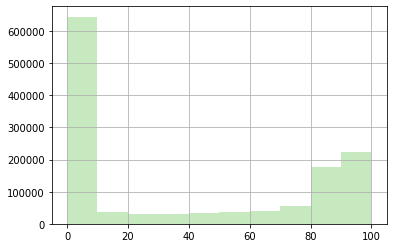

In [69]:
f.thlb_raw.hist()

In [70]:
f.reset_index(inplace=True)

In [71]:
def thlb_area(r):
    if r.tsa_code == '08':
        if r.thlb_raw < 90: 
            return 0.
        if r.SPECIES_CD_1 in species_spruce and r.SITE_INDEX < 10:
            return 0.
        if r.SPECIES_CD_1 in species_pine and r.SITE_INDEX < 15:
            return 0.
        if r.SPECIES_CD_1 in species_aspen and r.SITE_INDEX < 15:
            return 0.
        if r.SPECIES_CD_1 in species_fir and r.SITE_INDEX < 10:
            return 0.
        if r.SPECIES_CD_1 in ('SB', 'E', 'EA', 'EB', 'LT'):
            return 0
    return r.thlb_raw * r.FEATURE_AREA_SQM * 0.000001 

In [72]:
f['thlb_area'] = f.swifter.apply(thlb_area, axis=1)

In [73]:
#f.query('thlb == 1').groupby('tsa_code').FEATURE_AREA_SQM.sum() * 0.0001 

In [74]:
#f['thlb'] = f.swifter.apply(lambda r: 1 if r.thlb_area > 0 else 0, axis=1)

In [75]:
#f.query('thlb_raw > 69').groupby('tsa_code').FEATURE_AREA_SQM.sum() * 0.0001 

In [76]:
def assign_thlb(r):
    thlb_thresh = 50
    if r.tsa_code == '08':
        thlb_thresh = 93
    elif r.tsa_code == '24':
        thlb_thresh = 69
    return 1 if r.thlb_raw > thlb_thresh else 0

In [77]:
f['thlb'] = f.swifter.apply(assign_thlb, axis=1)

In [78]:
f.query('thlb == 1').groupby('tsa_code').FEATURE_AREA_SQM.sum() * 0.0001 

tsa_code
08    6.907580e+05
16    1.484429e+06
24    3.060473e+06
40    1.032886e+06
41    7.275775e+05
Name: FEATURE_AREA_SQM, dtype: float64

In [79]:
f.groupby('tsa_code').thlb_area.sum() 

tsa_code
08    6.573107e+05
16    1.435112e+06
24    2.909896e+06
40    1.017268e+06
41    7.143021e+05
Name: thlb_area, dtype: float64

In [80]:
def has_managed_curve(r):
    if r.thlb == 0: 
        return -1
    else:
        if np.isnan(au_table.loc[int(r.au)].managed_curve_id):
            return 0
        else:
            return 1

In [81]:
f.to_feather(ria_vri_vclr1p_checkpoint8_feather_path)

In [82]:
if 0:
    f = gpd.read_feather(ria_vri_vclr1p_checkpoint8_feather_path) 

In [83]:
if 0:
    f.to_file('./data/ria_vri-final.shp')
    !zip ./data/ria_vri-final_shp.zip ./data/ria_vri-final.*
    !mv ./data/ria_vri-final_shp.zip ./data/spadescbm_bundle/
    !zip -r ./data/spadescbm_bundle.zip ./data/spadescbm_bundle

In [84]:
def clean_geometry(r):
    from shapely.geometry import MultiPolygon
    g = r.geometry
    if not g.is_valid:
        _g = g.buffer(0)
        ################################
        # HACK
        # Something changed (maybe in fiona?) and now all GDB datasets are
        # loading as MultiPolygon geometry type (instead of Polygon). 
        # The buffer(0) trick smashes the geometry back to Polygon, 
        # so this hack upcasts it back to MultiPolygon.
        # 
        # Not sure how robust this is going to be (guessing not robust).
        _g = MultiPolygon([_g])
        assert _g.is_valid
        assert _g.geom_type == 'MultiPolygon'
        g = _g
    return g

In [85]:
def extract_features(f, tsa):
    f_ = f[['geometry', 'tsa_code', 'thlb', 'au', 'curve1', 'curve2', 'SPECIES_CD_1', 'PROJ_AGE_1', 'FEATURE_AREA_SQM']]
    f_ = f_.set_index('tsa_code').loc[tsa].reset_index()
    f_.geometry = f_.swifter.apply(clean_geometry, axis=1)
    return f_

In [86]:
#prop_names = [u'tsa_code', u'thlb', u'au', u'SPECIES_CD_1', u'PROJ_AGE_1', u'FEATURE_AREA_SQM']
prop_names = [u'tsa_code', u'thlb', u'au', u'canfi_species', u'PROJ_AGE_1', u'FEATURE_AREA_SQM']
prop_types = [(u'theme0', 'str:10'),
              (u'theme1', 'str:1'),
              (u'theme2', 'str:10'), 
              (u'theme3', 'str:5'), 
              (u'age', 'int:5'), 
              (u'area', 'float:10.1')]

In [87]:
columns = dict(zip(prop_names, dict(prop_types).keys()))

In [88]:
import os
for tsa in ria_tsas[:]:
    print('processing tsa', tsa)
    f_ = extract_features(f, tsa)
    try:
        os.mkdir('./data/shp/tsa%s.shp' % tsa)
    except:
        pass
    f_.rename(columns=columns, inplace=True)
    f_.theme0 = 'tsa' + f_.theme0
    f_.theme2 = f_.theme2.astype(int)
    f_.theme3 = f_.apply(lambda r: au_table.loc[r.au].canfi_species, axis=1)
    f_.age = f_.age.fillna(0)
    f_.age = f_.age.astype(int)
    f_.area = (f_.area * 0.0001).round(1)
    f_.to_file('./data/shp/tsa%s.shp/stands.shp' % tsa)

processing tsa 08


AttributeError: 'Series' object has no attribute 'au'

In [1]:
f_.head()

NameError: name 'f_' is not defined

In [205]:
!pwd

/media/data/project/gparadis/ria_yield


In [102]:
dx, dy = 20000, 5000
minx, miny, maxx, maxy = f_.geometry.total_bounds
bbox = Polygon([(maxx-dx, maxy), (maxx, maxy), (maxx, maxy-dy), (maxx-dx, maxy-dy)])

In [103]:
f__ = f_[f_.geometry.within(bbox)] 

In [ ]:
f__.plot()

In [105]:
f__.shape

(78, 8)

In [165]:
t1 = tp.Topology(f_)
t1.to_json('t1.json')

KeyboardInterrupt: 

In [167]:
t2 = tp.Topology(f_, simplify_with='simplification', simplify_algorithm='vw', toposimplify=1000, topoquantize=10000000)
#t2.to_json('t2.json')

Exception ignored on calling ctypes callback function: <function STRtree.query.<locals>.callback at 0x7fa3dbd5ed30>
Traceback (most recent call last):
  File "/opt/jupyterhub/lib/python3.8/site-packages/shapely/strtree.py", line 78, in callback
    def callback(item, userdata):
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <function STRtree.query.<locals>.callback at 0x7fa3cfbd29d0>
Traceback (most recent call last):
  File "/opt/jupyterhub/lib/python3.8/site-packages/shapely/strtree.py", line 78, in callback
    def callback(item, userdata):
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <function STRtree.query.<locals>.callback at 0x7fa3cfbd29d0>
Traceback (most recent call last):
  File "/opt/jupyterhub/lib/python3.8/site-packages/shapely/strtree.py", line 78, in callback
    def callback(item, userdata):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [163]:
!ls -lah t*.json

-rw-rw-r-- 1 gparadis gparadis 153K Mar 18 22:23 t1.json
-rw-rw-r-- 1 gparadis gparadis  37K Mar 18 22:32 t2.json


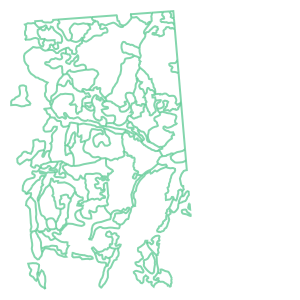

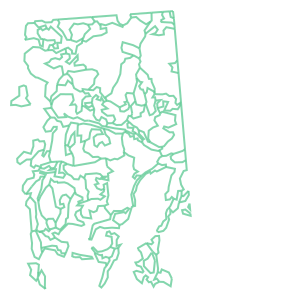

(None, None)

In [164]:
t1.to_svg(), t2.to_svg()

In [111]:
f_topo = tp.Topology(f__, simplify_with='simplification', simplify_algorithm='vw', toposimplify=0, topoquantize=0)
#f_topo.to_json('f.topo.json')

In [ ]:
f_topo.to_svg()

In [123]:
t = tp.Topology(f__, prevent_oversimplify=False)
t.to_widget()

interactive(children=(FloatSlider(value=0.01, description='Toposimplify Factor', max=10.0, step=0.01, style=Sl…

<function topojson.utils.toposimpquant(epsilon, quant, algo, topo)>

In [51]:
%%time 
f_.to_file('./data/shp/tsa08.shp/stands.shp')

CPU times: user 2min 24s, sys: 7.22 s, total: 2min 31s
Wall time: 2min 28s


In [ ]:
def clean_vector_data(src_path, dst_path, dst_name, prop_names, clean=True, tolerance=0.,
                      preserve_topology=True, logfn='clean_stand_shapefile.log', max_records=None,
                      theme0=None, prop_types=None, driver='ESRI Shapefile', dst_epsg=None,
                      update_area_prop=''):
    import logging
    import sys
    from shapely.geometry import mapping, shape, Polygon, MultiPolygon
    import fiona
    from collections import OrderedDict
    logging.basicConfig(filename=logfn, level=logging.INFO)
    snk1_path = '%s/%s.shp' % (dst_path, dst_name) 
    #snk2_path = dst_path[:-4]+'_error.shp' 
    snk2_path = '%s/%s_error.shp' % (dst_path, dst_name) 
    with fiona.open(src_path, 'r') as src:
        kwds1 = src.meta.copy()
        kwds2 = src.meta.copy()
        kwds1.update(driver=driver)
        kwds2.update(driver=driver)
        if dst_epsg:
            dst_crs = from_epsg(dst_epsg)
            kwds1.update(crs=dst_crs, crs_wkt=None)
        if not prop_types:
            prop_types = [('theme0', 'str:10')] if theme0 else []
            prop_types = prop_types + [(pn.lower(), src.schema['properties'][pn]) for pn in prop_names]
        kwds1['schema']['properties'] = OrderedDict(prop_types)
        kwds2['schema']['properties'] = OrderedDict(prop_types)
        print(kwds1)
        with fiona.open(snk1_path, 'w', **kwds1) as snk1, fiona.open(snk2_path, 'w', **kwds2) as snk2:
            n = len(src) if not max_records else max_records
            i = 0
            for f in src[:n]:
                i += 1
                prop_data = [('theme0', theme0)] if theme0 else []
                if prop_types:
                    prop_data = prop_data + [(prop_types[i+len(prop_data)][0], f['properties'][pn])
                                             for i, pn in enumerate(prop_names)]   
                else:
                    prop_data = prop_data + [(pn.lower(), f['properties'][pn]) for pn in prop_names]
                f.update(properties = OrderedDict(prop_data))
                try:
                    g = shape(f['geometry'])
                    if not g.is_valid:
                        _g = g.buffer(0)
                        ################################
                        # HACK
                        # Something changed (maybe in fiona?) and now all GDB datasets are
                        # loading as MultiPolygon geometry type (instead of Polygon). 
                        # The buffer(0) trick smashes the geometry back to Polygon, 
                        # so this hack upcasts it back to MultiPolygon.
                        # 
                        # Not sure how robust this is going to be (guessing not robust).
                        _g = MultiPolygon([_g])
                        assert _g.is_valid
                        assert _g.geom_type == 'MultiPolygon'
                        g = _g
                        ################################
                    ##################################################################
                    # The idea was to remove redundant vertices from polygons
                    # (to make datasets smaller, but also speed up geometry processing).
                    # This sort of worked, but was unstable so commented out for now.
                    # g = g.simplify(tolerance=tolerance, preserve_topology=True)
                    # if not g.is_valid:
                    #     _g = g.buffer(0)
                    #     assert _g.is_valid
                    #     assert _g.geom_type == 'Polygon'
                    #     g = _g
                    ##################################################################
                    f['geometry'] = mapping(g)
                    #print('geometry type 2', f['geometry']['type'])
                    if dst_epsg: f = reproject(f, src.crs, dst_crs)
                    if update_area_prop:
                        f['properties'][update_area_prop] = shape(f['geometry']).area
                    snk1.write(f)
                except Exception as e: # log exception and write uncleanable feature a separate shapefile
                    logging.exception("Error cleaning feature %s:", f['id'])
                    snk2.write(f)
    return snk1_path, snk2_path

tsa_code
08    1.049399e+06
16    1.435112e+06
24    2.909896e+06
40    1.017268e+06
41    7.143021e+05
Name: thlb_area, dtype: float64

In [175]:
if 0:
    f['has_managed_curve'] = f.swifter.apply(has_managed_curve, axis=1) 
    f[f.has_managed_curve == 0].thlb_raw.hist()
    f[f.has_managed_curve == 0]
    f[f.has_managed_curve == 1].thlb_raw.hist()
    f[f.has_managed_curve == 1]
    f[f.has_managed_curve == -1]

In [100]:
for tsa in ria_tsas:
    print(tsa)
    thlb_area = f.set_index('tsa_code').loc[tsa].query('thlb == 1').FEATURE_AREA_SQM.sum() * 0.0001
    print(thlb_area)

08
836545.05606871
16
923022.6680627001
24
3350540.6517824195
40
668307.1822495301
41
406439.80197317


In [127]:
#q = "thlb == 1 and BCLCS_LEVEL_5 != 'SP'"
q = "thlb == 1 and SITE_INDEX >= 5"

for tsa in ria_tsas:
    print(tsa)
    #thlb_area = f.set_index('tsa_code').loc[tsa].query("thlb == 1 and BCLCS_LEVEL_5 != 'SP'").FEATURE_AREA_SQM.sum() * 0.0001
    thlb_area = f.set_index('tsa_code').loc[tsa].query(q).FEATURE_AREA_SQM.sum() * 0.0001
    print(thlb_area)

08
1936681.2445122902
16
2092169.4377570702
24
3912796.82959853
40
1774472.6620997097
41
1267486.5773783


In [131]:
for tsa in ria_tsas:
    gdf = gpd.read_file('./data/ria_demo/input/gis/shp/tsa%s.shp/stands.shp' % tsa)
    print(gdf.query("theme1 == '1'").area.sum())


7863946461.321996
17589401276.048885
39386753880.209694
12070542045.839493
8849952108.594387


In [248]:
f.query('PROJ_AGE_1 < 50 and thlb == 0').FEATURE_AREA_SQM.sum() * 0.0001

898003.5737597403

In [246]:
f.query('PROJ_AGE_1 < 60 and thlb2 == 1').FEATURE_AREA_SQM.sum() * 0.0001

1874199.98050064

In [259]:
area_total = int(f.FEATURE_AREA_SQM.sum() * 0.0001)
area_total

20398321

In [260]:
area_thlb = int(f.query('thlb2 == 1').FEATURE_AREA_SQM.sum() * 0.0001)
area_thlb

6996124

In [261]:
area_thlb / area_total

0.3429754831292242

In [255]:
f[f.curve2 == f.curve1]

,FEATURE_ID,index,MAP_ID,POLYGON_ID,OPENING_IND,OPENING_SOURCE,OPENING_NUMBER,FEATURE_CLASS_SKEY,INVENTORY_STANDARD_CD,POLYGON_AREA,NON_PRODUCTIVE_DESCRIPTOR_CD,NON_PRODUCTIVE_CD,INPUT_DATE,COAST_INTERIOR_CD,SURFACE_EXPRESSION,...,thlb_raw,BEC_ZONE_CODE_lexmatch,SPECIES_CD_1_lexmatch,SPECIES_CD_2_lexmatch,stratum,stratum_lexmatch,stratum_matched,si_level,au,curve1,curve2,thlb,thlb_area,has_managed_curve,thlb2
0,7234204,2,094P039,64307717,N,None,None,843,V,7.5,None,None,None,I,P,...,0.000000,BWBS,SSB,LLT,BWBS_SB,BWBSBWBSBWBS_SSBSSB,BWBS_SB,M,802000.0,802000,802000,0,0.000000,-1,0
1,7176693,3,094P083,85153646,N,None,None,843,V,26.9,None,None,None,I,P,...,0.000000,BWBS,SSB,NaN,BWBS_SB,BWBSBWBSBWBS_SSBSSB,BWBS_SB,L,801000.0,801000,801000,0,0.000000,-1,0
2,4109532,4,094J100,337,N,7,None,843,V,9.3,None,None,None,I,P,...,77.700000,BWBS,SSW,SSB,BWBS_SW,BWBSBWBSBWBS_SSWSSW,BWBS_SW,M,802003.0,802003,802003,0,0.000000,-1,0
3,4112783,5,094K040,246,N,7,None,843,F,10.4,None,None,1994-04-26T00:00:00,I,None,...,0.000000,BWBS,AAT,NaN,BWBS_AT,BWBSBWBSBWBS_AATAAT,BWBS_AT,L,801001.0,801001,801001,0,0.000000,-1,0
4,4018593,6,094I081,161,N,None,None,843,V,5.0,None,None,None,I,P,...,100.000000,BWBS,AAT,SSB,BWBS_AT+SB,BWBSBWBSBWBS_AATAAT+SSB,BWBS_AT+SW,H,803008.0,803008,803008,1,5.043518,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414021,16346696,1990019,093I084,60841122,N,None,None,843,V,1.1,None,None,None,I,N,...,NaN,SBSx,PPL,SSX,SBS_PL,SBSxSBSxSBSx_PPLPPL,BWBS_PLI,M,4102003.0,4102003,4102003,0,NaN,-1,0
1414022,12463090,1990020,093O080,26846716,N,None,None,843,V,66.4,None,None,None,I,U,...,85.500000,ESSF,AAT,SSE,ESSF_AT+SE,ESSFESSFESSF_AATAAT+SSE,ESSF_SE,H,4103002.0,4103002,4103002,1,56.787711,1,1
1414023,7331768,1990021,093I086,71529616,N,None,None,843,V,19.8,None,None,None,I,N,...,61.285714,ESSF,SSE,BBL,ESSF_SE,ESSFESSFESSF_SSESSE,ESSF_SE,H,4103002.0,4103002,4103002,1,12.104791,1,1
1414024,8117584,1990022,093I039,36168302,N,None,None,843,V,38.3,None,None,None,I,P,...,36.771429,ESSF,SSE,NaN,ESSF_SE,ESSFESSFESSF_SSESSE,ESSF_SE,L,4101002.0,4101002,4101002,1,14.091828,1,0


In [ ]:
!zip ./data/ria_tmp-shp.zip ./data/ria_tmp.*

In [ ]:
./data/tsa_boundaries.feather

In [190]:
thlb_gdb = {}
for tsa in ria_tsas:
    print('importing TSA %s data' % tsa)
    thlb_gdb[tsa] = gpd.read_file('./data/thlb_gdb/bc_vri/tsa%s.gdb' % tsa, ignore_geometry=True)

importing TSA 08 data
importing TSA 16 data
importing TSA 24 data
importing TSA 40 data
importing TSA 41 data


In [191]:
f.reset_index(inplace=True)

In [192]:
f['thlb'] = 0
for tsa in ria_tsas:
    f_ = thlb_gdb[tsa]
    m = f[['FEATURE_ID']].merge(f_[['FEATURE_ID', 'THLB']], on='FEATURE_ID', how='left')#.set_index('FEATURE_ID')
    #f.set_index('FEATURE_ID', inplace=True)
    f['thlb'] = m.THLB.where(~m.THLB.isnull(), f.thlb)

In [193]:
f.set_index('tsa_code').loc['08'].query('thlb == 1')

,FEATURE_ID,index,MAP_ID,POLYGON_ID,OPENING_IND,OPENING_SOURCE,OPENING_NUMBER,FEATURE_CLASS_SKEY,INVENTORY_STANDARD_CD,POLYGON_AREA,NON_PRODUCTIVE_DESCRIPTOR_CD,NON_PRODUCTIVE_CD,INPUT_DATE,COAST_INTERIOR_CD,SURFACE_EXPRESSION,...,GEOMETRY_LEN,Shape_Length,Shape_Area,geometry,BEC_ZONE_CODE_lexmatch,SPECIES_CD_1_lexmatch,SPECIES_CD_2_lexmatch,stratum,stratum_lexmatch,stratum_matched,si_level,au,curve1,curve2,thlb
tsa_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
08,4109532,4,094J100,337,N,7,None,843,V,9.3,None,None,None,I,P,...,0.0,2953.724549,93159.912289,"MULTIPOLYGON (((1225011.710 1558755.596, 12250...",BWBS,SSW,SSB,BWBS_OP_SW,BWBSBWBSBWBS_OP_SSWSSW,BWBS_DE_SW,M,802005.0,802005,802005,1.0
08,4018593,6,094I081,161,N,None,None,843,V,5.0,None,None,None,I,P,...,0.0,1466.292917,50435.184471,"MULTIPOLYGON (((1232014.562 1547547.503, 12320...",BWBS,AAT,SSB,BWBS_DE_AT+SB,BWBSBWBSBWBS_DE_AATAAT+SSB,BWBS_DE_AT+SW,H,803007.0,803007,803007,1.0
08,4087936,9,094J074,24,N,None,None,843,V,2.4,None,None,None,I,N,...,0.0,724.526591,23796.974432,"MULTIPOLYGON (((1156041.310 1538029.665, 11560...",BWBS,SSW,SSB,BWBS_OP_SW,BWBSBWBSBWBS_OP_SSWSSW,BWBS_DE_SW,H,803005.0,803005,803005,1.0
08,4068290,14,094J046,136,N,7,None,843,V,4.5,None,None,None,I,N,...,0.0,1306.577721,45201.263678,"MULTIPOLYGON (((1178189.638 1503991.636, 11781...",BWBS,AAT,NaN,BWBS_OP_AT,BWBSBWBSBWBS_OP_AATAAT,BWBS_SP_AT,H,803003.0,803003,803003,1.0
08,8231887,17,094I100,65731308,N,None,None,843,V,6.2,None,None,None,I,P,...,0.0,1431.876239,62201.375385,"MULTIPOLYGON (((1337326.110 1566334.680, 13373...",BWBS,SSB,EEP,BWBS_OP_SB+EP,BWBSBWBSBWBS_OP_SSBSSB+EEP,BWBS_SP_SB,H,803002.0,823002,803002,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08,4242881,395390,094P011,790,N,7,None,843,V,7.7,None,None,None,I,U,...,0.0,1722.019687,77321.484431,"MULTIPOLYGON (((1240550.554 1576974.778, 12405...",BWBS,AAT,EEP,BWBS_DE_AT,BWBSBWBSBWBS_DE_AATAAT,BWBS_DE_AT,H,803000.0,803000,803000,1.0
08,4034470,395395,094J005,1471,N,4,None,843,V,1.2,None,None,None,I,U,...,0.0,467.380896,12329.831388,"MULTIPOLYGON (((1176041.207 1449658.602, 11760...",BWBS,AAT,SSB,BWBS_DE_AT,BWBSBWBSBWBS_DE_AATAAT,BWBS_DE_AT,H,803000.0,803000,803000,1.0
08,4185829,395400,094O012,251,N,None,None,843,V,16.2,None,None,None,I,N,...,0.0,2885.206726,162470.652033,"MULTIPOLYGON (((1137325.279 1577638.949, 11373...",BWBS,SSW,AAT,BWBS_OP_SW+AT,BWBSBWBSBWBS_OP_SSWSSW+AAT,BWBS_DE_SW,H,803005.0,803005,803005,1.0


In [ ]:
f.to_file('./data/ria_tmp.shp')

In [ ]:
f